In [10]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.pipeline import Pipeline
from matplotlib import ticker, cm

from swimnetworks import (Dense, Linear)
np.set_printoptions(threshold=np.inf)

In [11]:
def tanh_x(x):
    """First derivative of tanh.
    """
    x = np.clip(x, -10, 10)
    return 1/np.cosh(x)**2

In [12]:
# setup the problem ODE
def u_true(x):
    return np.sin(x[:,0]) + np.sin(x[:,1])
def u_true_grad(x):
    return np.cos(x[:,0]) + np.cos(x[:,1])

# def heat_double_grad(x):
#     return 0

# x_plot = np.linspace(-np.pi, np.pi, 1000).reshape((-1, 1))

# fig, ax = plt.subplots(1, 1)
# ax.plot(x_plot, u_true(x_plot), label='Solution')
# ax.plot(x_plot, u_true_grad(x_plot), label='Solution gradient')
# ax.legend()

In [13]:
activation = np.tanh
activation_x = tanh_x

def solve_swim_PINN(subdomains, u_true_train, u_grad_train, u_boundary_train, layer_width, random_state=1):
    """Construct a list of PINNs that solve a simple ode over a decomposed domain.
    The ode to solve is $u_x=f(u(x))$, for $x$ in 2D with domain decomposition."""
    # construct good basis functions by sampling activation functions based on the known data
    # we must run over all domains and create models for each
    def fit_model(inner_train, boundary_train, shared_train, i):
        model_ansatz = Pipeline([
            ("hidden", Dense(
                layer_width=layer_width,
                activation=activation,
                parameter_sampler='tanh',
                random_seed=random_state)),
            ("linear", Linear(regularization_scale=1e-10))]
        )
        model_ansatz.fit(inner_train, u_true_train[i])

        hidden_layer = model_ansatz.steps[0][1]

        # setup the linear system to solve for the outer coefficietns
        # first, evaluate the gradient of the ansatz function
        hidden_layer.activation = activation_x
        u_x = hidden_layer.predict(inner_train) * hidden_layer.weights[0,:]
        u_y = hidden_layer.predict(inner_train) * hidden_layer.weights[1,:]

        uxy = u_x + u_y

        # evaluate it on the boundary as well
        hidden_layer.activation = activation
        u_boundary = hidden_layer.predict(boundary_train)
        
        u_shared = []
        for j in range(4):
            if not shared_train[j] is None:
                u_shared.append(hidden_layer.predict(shared_train[j]))
            else:
                u_shared.append(None)

        return model_ansatz, uxy, u_boundary, u_shared

    model_data = []
    n_rows = 0
    shared_rows = 0

    for i in range(len(subdomains)):
        model_data.append(fit_model(subdomains[i].inner_train, subdomains[i].boundary_train, subdomains[i].shared_train, i))
        for j in range(4):
            if not subdomains[i].shared_train[j] is None:
                shared_rows += model_data[i][3][j].shape[0]

        n_rows += model_data[i][1].shape[0] + model_data[i][2].shape[0]
    
    shared_rows = shared_rows/2
    n_rows += shared_rows
    n_columns = (layer_width+1)*len(subdomains)

    # setup the linear system inputs and outputs
    # also add the bias term
    matrix_in = np.zeros((int(n_rows), n_columns))
    matrix_out = np.empty((0, 1))

    # For gradient and boundary points
    row_start = 0
    column_start = 0
    for i in range(len(subdomains)):
        n_row = model_data[i][1].shape[0]
        matrix_in[row_start:row_start+n_row, column_start:(i+1)*(layer_width+1)] = np.column_stack([model_data[i][1], np.zeros(model_data[i][1].shape[0])])
        row_start += n_row
        n_row = model_data[i][2].shape[0]
        matrix_in[row_start:row_start+n_row, column_start:(i+1)*(layer_width+1)] = np.column_stack([model_data[i][2], np.ones(model_data[i][2].shape[0])])
        row_start += n_row
        column_start = (i+1)*(layer_width+1)

    # For shared points
    for i in range(len(subdomains)):    ####################    Possibly completely filled with bugs
        if not subdomains[i].shared_train[0] is None:
            n_row = model_data[i][3][0].shape[0]
            # print(np.column_stack([-model_data[subdomains[i].neighbors[0]][3][3], -np.ones((model_data[subdomains[i].neighbors[0]][3][3].shape[0],1))]))
            matrix_in[row_start:row_start+n_row, i*(layer_width+1):(i+1)*(layer_width+1)] = np.column_stack([model_data[i][3][0], np.ones((model_data[i][3][0].shape[0],1))])
            matrix_in[row_start:row_start+n_row, subdomains[i].neighbors[0]*(layer_width+1):(subdomains[i].neighbors[0]+1)*(layer_width+1)] = np.column_stack([-model_data[subdomains[i].neighbors[0]][3][3], -np.ones((model_data[subdomains[i].neighbors[0]][3][3].shape[0],1))])
            row_start += n_row

        if not subdomains[i].shared_train[2] is None:
            n_row = model_data[i][3][2].shape[0]
            matrix_in[row_start:row_start+n_row, i*(layer_width+1):(i+1)*(layer_width+1)] = np.column_stack([model_data[i][3][2], np.ones((model_data[i][3][2].shape[0],1))])
            matrix_in[row_start:row_start+n_row, subdomains[i].neighbors[2]*(layer_width+1):(subdomains[i].neighbors[2]+1)*(layer_width+1)] = np.column_stack([-model_data[subdomains[i].neighbors[2]][3][1], -np.ones((model_data[subdomains[i].neighbors[2]][3][1].shape[0],1))]) 
            row_start += n_row

        if i == 0:
            if not subdomains[i].shared_train[1] is None:
                n_row = model_data[i][3][1].shape[0]
                matrix_in[row_start:row_start+n_row, i*(layer_width+1):(i+1)*(layer_width+1)] = np.column_stack([-model_data[i][3][1], -np.ones((model_data[i][3][1].shape[0],1))])
                matrix_in[row_start:row_start+n_row, subdomains[i].neighbors[1]*(layer_width+1):(subdomains[i].neighbors[1]+1)*(layer_width+1)] = np.column_stack([model_data[subdomains[i].neighbors[1]][3][2], np.ones((model_data[subdomains[i].neighbors[1]][3][2].shape[0],1))])
                row_start += n_row
            
            if not subdomains[i].shared_train[3] is None:
                n_row = model_data[i][3][3].shape[0]
                matrix_in[row_start:row_start+n_row, i*(layer_width+1):(i+1)*(layer_width+1)] = np.column_stack([-model_data[i][3][3], -np.ones((model_data[i][3][3].shape[0],1))])
                matrix_in[row_start:row_start+n_row, subdomains[i].neighbors[3]*(layer_width+1):(subdomains[i].neighbors[3]+1)*(layer_width+1)] = np.column_stack([model_data[subdomains[i].neighbors[3]][3][0], np.ones((model_data[subdomains[i].neighbors[3]][3][0].shape[0],1))]) 
                row_start += n_row
            

    # matrix_in = np.row_stack([
    #     np.column_stack([left_data[1], np.zeros(left_data[1].shape[0]), 0*right_data[1], 0*np.zeros(right_data[1].shape[0])]),    # gradient
    #     np.column_stack([0*left_data[1], np.zeros(left_data[1].shape[0]), right_data[1], np.zeros(right_data[1].shape[0])]),    # gradient
    #     np.column_stack([left_data[2], np.ones(left_data[2].shape[0]), 0*right_data[2], np.zeros(right_data[2].shape[0])]),   # boundary left
    #     #np.column_stack([0*left_data[2], np.zeros(left_data[2].shape[0]), right_data[2], np.ones(right_data[2].shape[0])]),   # boundary right
    #     np.column_stack([left_data[3], np.ones(left_data[3].shape[0]), -right_data[3], -np.ones(right_data[3].shape[0])]),     # shared boundary
    # ])

    # construct the output matrix for gradient and boundary points
    for i in range(len(subdomains)):
        matrix_out = np.row_stack([
            matrix_out,
            u_grad_train[i],
            u_boundary_train[i],
        ])

    # append output matrix for shared points
    matrix_out = np.row_stack([
                    matrix_out,
                    np.zeros((int(shared_rows),1))
                ])
    
    # print(matrix_in)
    # solve
    c = np.linalg.lstsq(matrix_in, matrix_out, rcond=1e-10)[0]

    c_subdomains = []
    for i in range(len(subdomains)):
        c_subdomains.append(c[i*(layer_width+1):(i+1)*(layer_width+1)])
        model_data[i][0].steps[1][1].weights = c_subdomains[i][:-1]
        model_data[i][0].steps[1][1].biases = c_subdomains[i][-1]


    def combined_model(x, y):
        
        for i in range(len(subdomains)):
            mask_x = (x > subdomains[i].xbounds[0]) & (x <= subdomains[i].xbounds[1])
            mask_y = (y > subdomains[i].ybounds[0]) & (y <= subdomains[i].ybounds[1])
            if i==0:
                model_pred = model_data[i][0].predict(np.column_stack([x,y])) * mask_x * mask_y
            else:    
                model_pred += model_data[i][0].predict(np.column_stack([x,y])) * mask_x * mask_y
            # left_pred = left_data[0].predict(x) * (x < x_boundary_inner)
            # right_pred = right_data[0].predict(x) * (x >= x_boundary_inner)
        
        return model_pred

    return combined_model



In [14]:
class subdomain:
    def __init__(self, rank, nx, ny, n_subdomains, n_pts_train, lims, x, y):
        self.rank = rank
        self.nx = nx
        self.ny = ny
        self.n_subdomains = n_subdomains
        self.lims = lims
        self.neighbors = [self.rank+self.nx, self.rank-1, self.rank+1, self.rank-self.nx]  # Top, left, right, bottom
        self.x_shared = np.empty(4, dtype=object)
        self.y_shared = np.empty(4, dtype=object)
        self.x_boundary = np.array([])
        self.y_boundary = np.array([])
        self.shared_train = np.empty(4, dtype=object)

        if self.rank%nx == 0:
            self.neighbors[1] = -2
        if int(self.rank/nx) == 0:
            self.neighbors[3] = -2
        if self.rank%nx == nx-1:
            self.neighbors[2] = -2
        if int(self.rank/nx) == ny-1:
            self.neighbors[0] = -2

        self.xindexbounds = [int((self.rank%self.nx)*(n_pts_train-1)/nx), int((self.rank%self.nx + 1)*(n_pts_train-1)/nx)]
        self.yindexbounds = [int(int(self.rank/self.nx)*(n_pts_train-1)/ny), int((int(self.rank/self.nx)+1)*(n_pts_train-1)/ny)]
        # self.xbounds = np.empty(2)
        # self.ybounds = np.empty(2)

        self.xbounds = np.array([x[self.xindexbounds[0]], x[self.xindexbounds[1]]])
        self.ybounds = np.array([y[self.yindexbounds[0]], y[self.yindexbounds[1]]])
        
        if (self.neighbors[0] < 0):
            self.ybounds[1] = lims[1]
        if (self.neighbors[1] < 0):
            self.xbounds[0] = lims[0]
        if (self.neighbors[2] < 0):
            self.xbounds[1] = lims[1]
        if (self.neighbors[3] < 0):
            self.ybounds[0] = lims[0]            
        # print(self.xbounds)
        # print(self.ybounds)

    def set_inner_points(self, x_t, y_t):
        self.x_inner = x_t[self.yindexbounds[0]:self.yindexbounds[1]+1, self.xindexbounds[0]:self.xindexbounds[1]+1]
        self.y_inner = y_t[self.yindexbounds[0]:self.yindexbounds[1]+1, self.xindexbounds[0]:self.xindexbounds[1]+1]
        # print(self.y_inner)

    def set_shared_points(self):
        tempx = self.x_inner
        tempy = self.y_inner
        if self.neighbors[0] >= 0:
            self.x_shared[0] = self.x_inner[-1,:]
            tempx = np.delete(tempx, -1, axis=0)
            self.y_shared[0] = self.y_inner[-1,:]
            tempy = np.delete(tempy, -1, axis=0)
            self.shared_train[0] = np.column_stack([self.x_shared[0], self.y_shared[0]])
        if self.neighbors[1] >= 0:
            self.x_shared[1] = self.x_inner[:,0]
            tempx = np.delete(tempx, 0, axis=1)
            self.y_shared[1] = self.y_inner[:,0]
            tempy = np.delete(tempy, 0, axis=1)
            self.shared_train[1] = np.column_stack([self.x_shared[1], self.y_shared[1]])
        if self.neighbors[2] >= 0:
            self.x_shared[2] = self.x_inner[:,-1]
            tempx = np.delete(tempx, -1, axis=1)
            self.y_shared[2] = self.y_inner[:,-1]
            tempy = np.delete(tempy, -1, axis=1)
            self.shared_train[2] = np.column_stack([self.x_shared[2], self.y_shared[2]])
        if self.neighbors[3] >= 0:
            self.x_shared[3] = self.x_inner[0,:]
            tempx = np.delete(tempx, 0, axis=0)
            self.y_shared[3] = self.y_inner[0,:]
            tempy = np.delete(tempy, 0, axis=0)
            self.shared_train[3] = np.column_stack([self.x_shared[3], self.y_shared[3]])
        self.x_inner = tempx
        self.y_inner = tempy

    def set_boundary_points(self):
        if self.neighbors[0] < 0:
            self.x_boundary = np.append(self.x_boundary, self.x_inner[-1,:])
            self.y_boundary = np.append(self.y_boundary, self.lims[1]*np.ones(len(self.x_inner[-1,:])))
        if self.neighbors[1] < 0:
            self.x_boundary = np.append(self.x_boundary, self.lims[0]*np.ones(len(self.y_inner[:,0])))
            self.y_boundary = np.append(self.y_boundary, self.y_inner[:,0])
        if self.neighbors[2] < 0:
            self.x_boundary = np.append(self.x_boundary, self.lims[1]*np.ones(len(self.y_inner[:,-1])))
            self.y_boundary = np.append(self.y_boundary, self.y_inner[:,-1])
        if self.neighbors[3] < 0:
            self.x_boundary = np.append(self.x_boundary, self.x_inner[0,:])
            self.y_boundary = np.append(self.y_boundary, self.lims[0]*np.ones(len(self.x_inner[0,:])))

    def set_training_points(self):
        self.x_inner = self.x_inner.reshape(-1,1)
        self.y_inner = self.y_inner.reshape(-1,1)
        self.inner_train = np.column_stack([self.x_inner, self.y_inner])
        self.boundary_train = np.column_stack([self.x_boundary, self.y_boundary])
        # print(self.inner_train)
        # print(self.boundary_train)
        # print(self.shared_train)
        # self.x_boundary = self.x_boundary.unsqueeze(-1,1)

        
        

In [15]:
# Domain and subdomain generation
random_state = 1
rng = np.random.default_rng(random_state)
lims = [-1*np.pi, 1*np.pi] # Domain bounds considering square for now
n_pts_train = 150


# Generating the entire domain
x = np.sort(rng.uniform(lims[0], lims[1], size=(n_pts_train, 1)), axis = 0)
y = np.sort(rng.uniform(lims[0], lims[1], size=(n_pts_train, 1)), axis = 0)
x_t, y_t = np.meshgrid(x, y)


# Number of subdomains
n_subdomains = 2 # Cartesian splits 
nx = 2
ny = 1 # nx*ny = n_subdomains, Change for rectangular domains


# Defines neighbors and bounds for each subdomain and stores part of global matrix for subdomain
subdomains = []
for j in range(ny):
    for i in range(nx):
        sub = subdomain(j*nx+i, nx, ny, n_subdomains, n_pts_train, lims, x, y)
        subdomains.append(sub)
        subdomains[j*nx+i].set_inner_points(x_t, y_t)
        subdomains[j*nx+i].set_shared_points() 
        subdomains[j*nx+i].set_boundary_points()  
        subdomains[j*nx+i].set_training_points()

u_grad_train = []
u_true_train = []
u_boundary_train = []

for i in range(n_subdomains):
    u_grad_train.append(u_true_grad(subdomains[i].inner_train).reshape((-1,1)))
    u_true_train.append(u_true(subdomains[i].inner_train).reshape((-1,1)))
    u_boundary_train.append(u_true(subdomains[i].boundary_train).reshape((-1,1)))





In [16]:
# layer_widths = np.linspace(10, 100, 5).astype(int)
subdomain_layer_width = 10000
# fig, ax = plt.subplots(1, len(layer_widths), figsize=(20, 3), sharey=True)

error = []
t0 = time()

model = solve_swim_PINN(subdomains, u_true_train, u_grad_train, u_boundary_train, layer_width=int(subdomain_layer_width), random_state=1)

# x_plot = np.linspace(-1*np.pi, 1*np.pi, 300).reshape((-1, 1))
# x_p, y_p = np.meshgrid(x_plot, x_plot)
x_t = x_t.reshape(n_pts_train*n_pts_train,1)
y_t = y_t.reshape(n_pts_train*n_pts_train,1)
domain_test = np.column_stack([x_t, y_t]) 
# print(np.squeeze(model(x_t,y_t)))
# print(u_true(domain_test))
error = np.linalg.norm(np.squeeze(model(x_t, y_t))-u_true(domain_test), 1)

print(error)

print("time for solving and plotting:", time()-t0, "seconds.")

0.0009875271301253014
time for solving and plotting: 10052.429999828339 seconds.


Text(0, 0.5, 'y')

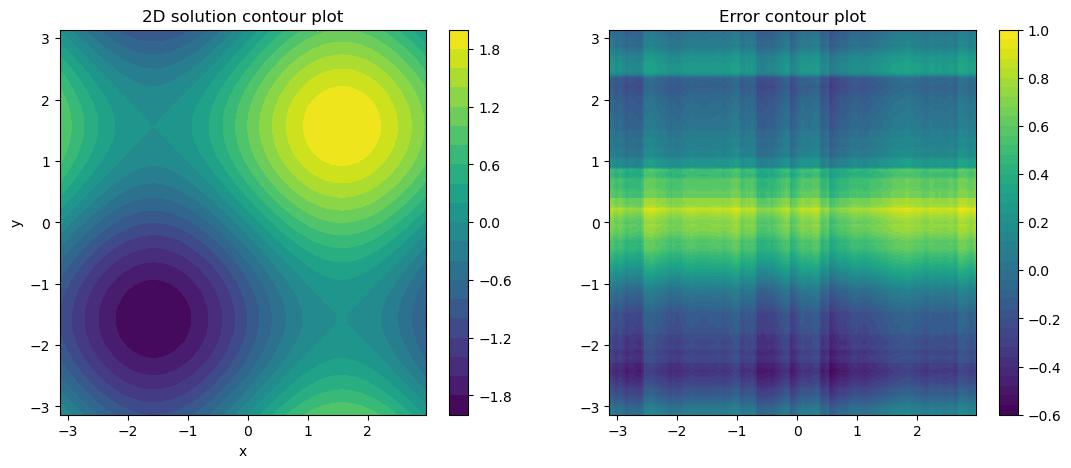

In [21]:
rng = np.random.default_rng(3)
x = np.sort(rng.uniform(lims[0], lims[1], size=(n_pts_train, 1)), axis = 0)
y = np.sort(rng.uniform(lims[0], lims[1], size=(n_pts_train, 1)), axis = 0)
x_t, y_t = np.meshgrid(x, y)
solution = model(x_t.reshape(-1,1), y_t.reshape(-1,1))

error = np.squeeze(solution) - u_true(domain_test)

error = error.reshape(n_pts_train, n_pts_train)

solution = solution.reshape(n_pts_train, n_pts_train)

x_t = x_t.reshape(n_pts_train, n_pts_train)
y_t = y_t.reshape(n_pts_train, n_pts_train)

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
contour1 = ax[0].contourf(x_t, y_t, solution, levels=20, cmap='viridis')
contour2 = ax[1].contourf(x_t, y_t, error, levels=40, cmap = 'viridis')  #locator=ticker.LogLocator(), cmap='viridis')

colorbar = plt.colorbar(contour1, ax=ax[0])
colorbar = plt.colorbar(contour2, ax=ax[1])

ax[0].set_title('2D solution contour plot')
ax[1].set_title('Error contour plot')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')